<a href="https://colab.research.google.com/github/tayssirsem/MicroE/blob/main/MicroE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===============================
# Dataset download (KaggleHub)
# ===============================
import kagglehub
import os

# ===============================
# Core libraries
# ===============================
import numpy as np
import pandas as pd

# ===============================
# TensorFlow / Keras
# ===============================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ===============================
# Visualization
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# Utilities
# ===============================
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadsaadkhankori/microexpression")

print("Path to dataset files:", path)

100%|██████████| 64.6M/64.6M [00:00<00:00, 143MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhammadsaadkhankori/microexpression/versions/1


In [3]:
import os

for root, dirs, files in os.walk(path):
    print(root)
    print("Dirs:", dirs)
    print("Files:", files[:5])
    break


/root/.cache/kagglehub/datasets/muhammadsaadkhankori/microexpression/versions/1
Dirs: ['train']
Files: []


In [4]:
!find $path -maxdepth 3 -type d


/root/.cache/kagglehub/datasets/muhammadsaadkhankori/microexpression/versions/1
/root/.cache/kagglehub/datasets/muhammadsaadkhankori/microexpression/versions/1/train
/root/.cache/kagglehub/datasets/muhammadsaadkhankori/microexpression/versions/1/train/fear
/root/.cache/kagglehub/datasets/muhammadsaadkhankori/microexpression/versions/1/train/sadness
/root/.cache/kagglehub/datasets/muhammadsaadkhankori/microexpression/versions/1/train/disgust
/root/.cache/kagglehub/datasets/muhammadsaadkhankori/microexpression/versions/1/train/anger
/root/.cache/kagglehub/datasets/muhammadsaadkhankori/microexpression/versions/1/train/happiness
/root/.cache/kagglehub/datasets/muhammadsaadkhankori/microexpression/versions/1/train/surprise


In [5]:
DATASET_DIR ="/kaggle/input/microexpression/MicroExpression"


In [6]:
import os

def find_image_root(base_path):
    for root, dirs, files in os.walk(base_path):
        # condition: contains subfolders AND image files inside them
        for d in dirs:
            sub = os.path.join(root, d)
            if any(f.lower().endswith(('.jpg', '.png', '.jpeg'))
                   for f in os.listdir(sub)):
                return root
    return None

DATASET_DIR = find_image_root(path)
print("Detected DATASET_DIR:", DATASET_DIR)


Detected DATASET_DIR: /root/.cache/kagglehub/datasets/muhammadsaadkhankori/microexpression/versions/1/train


In [7]:
!ls "$DATASET_DIR"


anger  disgust	fear  happiness  sadness  surprise


Modele CNN:



In [8]:
import tensorflow as tf

img_size = (224, 224)
batch_size = 32
seed = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)


Found 9000 files belonging to 6 classes.
Using 7200 files for training.
Found 9000 files belonging to 6 classes.
Using 1800 files for validation.
Classes: ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
Number of classes: 6


In [9]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])


In [10]:
from tensorflow.keras import models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=img_size + (3,)),
    data_augmentation,

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(
    monitor='val_loss',    # watch validation loss
    patience=4,            # stop if no improvement in 5 epochs
    restore_best_weights=True
)


In [13]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)


In [14]:
epochs = 50  # can use higher, early stopping will stop automatically

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2353 - loss: 1.9434

225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.2356 - loss: 1.9421 - val_accuracy: 0.4739 - val_loss: 1.2419
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4606 - loss: 1.3099

225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.4607 - loss: 1.3097 - val_accuracy: 0.5578 - val_loss: 1.0783
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5554 - loss: 1.1069

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.5555 - loss: 1.1068 - val_accuracy: 0.6461 - val_loss: 0.8324
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5976 - loss: 1.0055

225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.5976 - loss: 1.0054 - val_accuracy: 0.7144 - val_loss: 0.7549
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6452 - loss: 0.9048

225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.6451 - loss: 0.9048 - val_accuracy: 0.7483 - val_loss: 0.6684
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6595 - loss: 0.8386

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.6596 - loss: 0.8386 - val_accuracy: 0.7539 - val_loss: 0.6334
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6851 - loss: 0.7820

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.6851 - loss: 0.7820 - val_accuracy: 0.8078 - val_loss: 0.5637
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7008 - loss: 0.7325

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.7009 - loss: 0.7325 - val_accuracy: 0.7978 - val_loss: 0.5025
Epoch 9/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7256 - loss: 0.6807

225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.7256 - loss: 0.6806 - val_accuracy: 0.8117 - val_loss: 0.4529
Epoch 10/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7416 - loss: 0.6388

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.7416 - loss: 0.6388 - val_accuracy: 0.8356 - val_loss: 0.4389
Epoch 11/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7562 - loss: 0.6008

225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.7562 - loss: 0.6009 - val_accuracy: 0.8506 - val_loss: 0.4039
Epoch 12/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7706 - loss: 0.5769

225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.7706 - loss: 0.5769 - val_accuracy: 0.8722 - val_loss: 0.3806
Epoch 13/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7758 - loss: 0.5334

225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.7758 - loss: 0.5334 - val_accuracy: 0.8478 - val_loss: 0.3618
Epoch 14/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7863 - loss: 0.5266

225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.7863 - loss: 0.5266 - val_accuracy: 0.8789 - val_loss: 0.3356
Epoch 15/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7995 - loss: 0.5038

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.7995 - loss: 0.5039 - val_accuracy: 0.8683 - val_loss: 0.3106
Epoch 16/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.8082 - loss: 0.4580 - val_accuracy: 0.8656 - val_loss: 0.3421
Epoch 17/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8055 - loss: 0.4731

225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.8055 - loss: 0.4731 - val_accuracy: 0.8933 - val_loss: 0.2863
Epoch 18/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8194 - loss: 0.4407

225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.8195 - loss: 0.4406 - val_accuracy: 0.8967 - val_loss: 0.2546
Epoch 19/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8374 - loss: 0.4215

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.8374 - loss: 0.4215 - val_accuracy: 0.9056 - val_loss: 0.2537
Epoch 20/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8414 - loss: 0.3990

225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.8414 - loss: 0.3990 - val_accuracy: 0.9150 - val_loss: 0.2227
Epoch 21/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.8459 - loss: 0.3915 - val_accuracy: 0.9128 - val_loss: 0.2242
Epoch 22/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8487 - loss: 0.3565

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.8487 - loss: 0.3565 - val_accuracy: 0.9178 - val_loss: 0.2063
Epoch 23/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8561 - loss: 0.3616

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.8561 - loss: 0.3616 - val_accuracy: 0.9206 - val_loss: 0.1995
Epoch 24/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8560 - loss: 0.3555

225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.8560 - loss: 0.3555 - val_accuracy: 0.9289 - val_loss: 0.1901
Epoch 25/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.8701 - loss: 0.3351 - val_accuracy: 0.9194 - val_loss: 0.1937
Epoch 26/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8740 - loss: 0.3147

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.8740 - loss: 0.3148 - val_accuracy: 0.9289 - val_loss: 0.1866
Epoch 27/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.8773 - loss: 0.3185 - val_accuracy: 0.9228 - val_loss: 0.1880
Epoch 28/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8651 - loss: 0.3386

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.8651 - loss: 0.3386 - val_accuracy: 0.9333 - val_loss: 0.1764
Epoch 29/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8793 - loss: 0.2901

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.8793 - loss: 0.2901 - val_accuracy: 0.9372 - val_loss: 0.1568
Epoch 30/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8757 - loss: 0.3090

225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.8757 - loss: 0.3089 - val_accuracy: 0.9433 - val_loss: 0.1502
Epoch 31/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.8844 - loss: 0.2895 - val_accuracy: 0.9289 - val_loss: 0.1640
Epoch 32/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8907 - loss: 0.2778

225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.8906 - loss: 0.2778 - val_accuracy: 0.9439 - val_loss: 0.1303
Epoch 33/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.8995 - loss: 0.2607 - val_accuracy: 0.9511 - val_loss: 0.1512
Epoch 34/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8860 - loss: 0.2872

225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.8860 - loss: 0.2872 - val_accuracy: 0.9656 - val_loss: 0.1238
Epoch 35/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8858 - loss: 0.2691

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.8858 - loss: 0.2690 - val_accuracy: 0.9550 - val_loss: 0.1116
Epoch 36/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8980 - loss: 0.2670

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.8980 - loss: 0.2670 - val_accuracy: 0.9633 - val_loss: 0.1056
Epoch 37/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.8951 - loss: 0.2499 - val_accuracy: 0.9411 - val_loss: 0.1568
Epoch 38/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.9104 - loss: 0.2293 - val_accuracy: 0.9589 - val_loss: 0.1110
Epoch 39/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.9021 - loss: 0.2480 - val_accuracy: 0.9533 - val_loss: 0.1144
Epoch 40/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.9059 - loss: 0.2382 - val_accuracy: 0.9511 - val_loss: 0.1129


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
# Collect all images and labels from validation dataset
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━

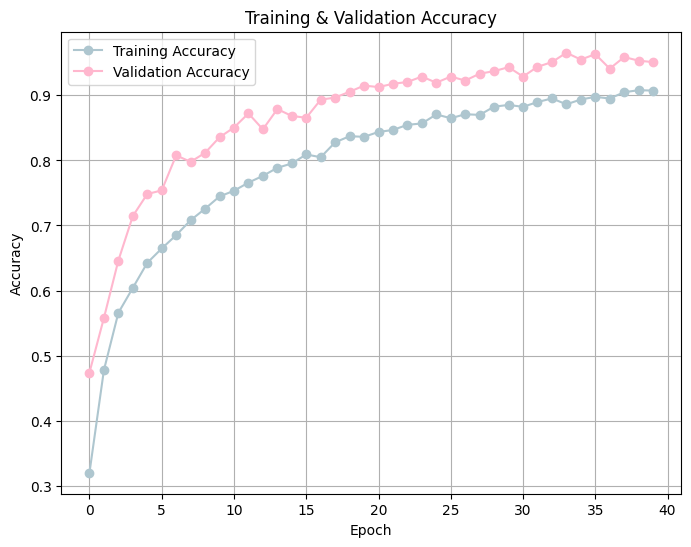

In [47]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'],color='#AEC6CF', label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'],color='#FFB7CE', label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


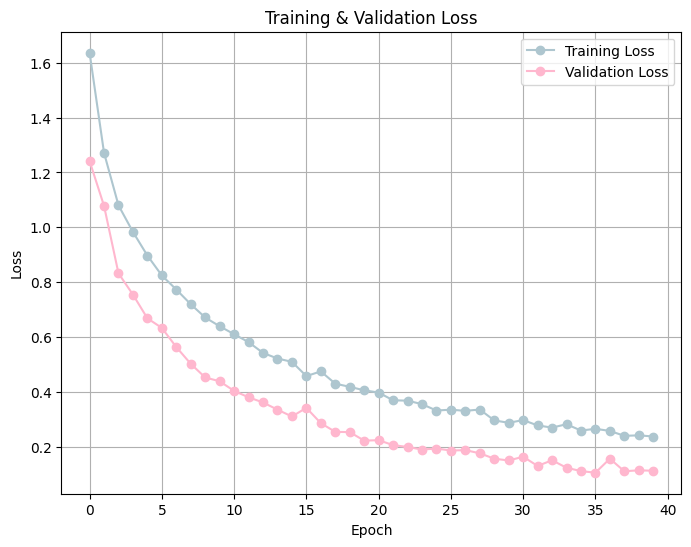

In [48]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'],color='#AEC6CF', label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], color='#FFB7CE',label='Validation Loss', marker='o')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


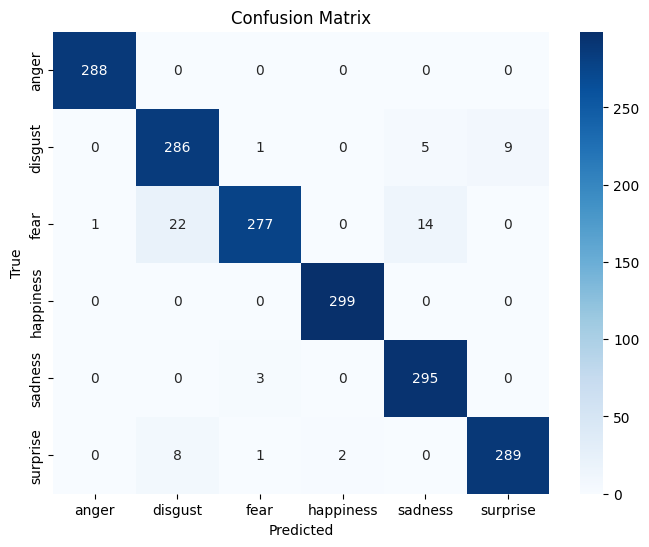

In [19]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [20]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

       anger       1.00      1.00      1.00       288
     disgust       0.91      0.95      0.93       301
        fear       0.98      0.88      0.93       314
   happiness       0.99      1.00      1.00       299
     sadness       0.94      0.99      0.96       298
    surprise       0.97      0.96      0.97       300

    accuracy                           0.96      1800
   macro avg       0.96      0.96      0.96      1800
weighted avg       0.96      0.96      0.96      1800



In [21]:
accuracy = np.sum(y_true == y_pred) / len(y_true)
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.9633


Modele RNN:


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



In [23]:
train_ds = train_ds.unbatch()
val_ds = val_ds.unbatch()


In [24]:
def preprocess_rnn(image, label):
    # normalize
    image = tf.cast(image, tf.float32) / 255.0
    # reshape image to sequence for RNN
    seq_len = img_size[0]
    features = img_size[1] * 3
    image = tf.reshape(image, (seq_len, features))
    # make label 1D
    label = tf.cast(label, tf.int32)
    label = tf.squeeze(label)
    return image, label



In [25]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

train_ds_rnn = train_ds.map(preprocess_rnn, num_parallel_calls=AUTOTUNE) \
                       .shuffle(1000) \
                       .batch(batch_size, drop_remainder=True) \
                       .prefetch(AUTOTUNE)

val_ds_rnn = val_ds.map(preprocess_rnn, num_parallel_calls=AUTOTUNE) \
                   .batch(batch_size, drop_remainder=True) \
                   .prefetch(AUTOTUNE)


In [26]:
for images, labels in train_ds_rnn.take(1):
    print("Images:", images.shape)  # (batch_size, 224, 672)
    print("Labels:", labels.shape)  # (batch_size,)

Images: (32, 224, 672)
Labels: (32,)


In [27]:
from tensorflow.keras import layers, models

model_rnn = models.Sequential([
    layers.Input(shape=(img_size[0], img_size[1]*3)),
    layers.LSTM(128),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_rnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_rnn.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       410,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 418,758 (1.60 MB)

 Trainable params: 418,758 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_rnn = model_rnn.fit(
    train_ds_rnn,
    validation_data=val_ds_rnn,
    epochs=50,
    callbacks=[early_stop]
)



Epoch 1/30
    223/Unknown 12s 43ms/step - accuracy: 0.2668 - loss: 1.6424

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.2672 - loss: 1.6413 - val_accuracy: 0.3213 - val_loss: 1.3864
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.3662 - loss: 1.4092 - val_accuracy: 0.3794 - val_loss: 1.2723
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.4073 - loss: 1.3087 - val_accuracy: 0.4464 - val_loss: 1.1904
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.4641 - loss: 1.2037 - val_accuracy: 0.4561 - val_loss: 1.2319
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.4792 - loss: 1.1697 - val_accuracy: 0.5197 - val_loss: 1.0197
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.5422 - loss: 1.0396 - val_accuracy: 0.5609 - val_loss: 0.9744
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.5645 - loss: 0.9772 - val_accuracy: 0.5938 - val_loss: 0.8479
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.5977 - loss: 0.9062 - val_accura

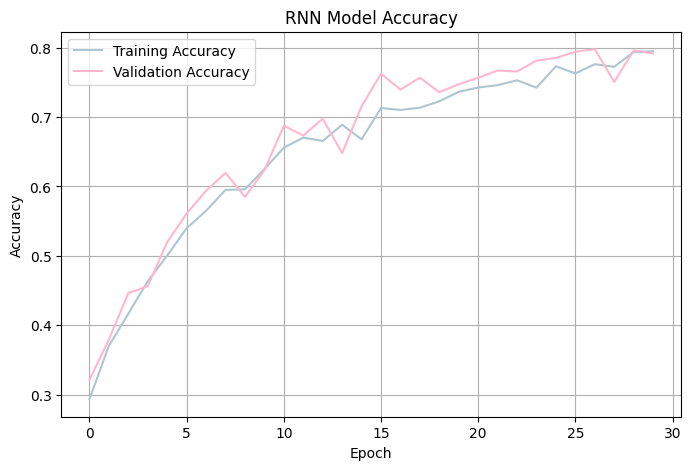

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history_rnn.history['accuracy'],color='#AEC6CF', label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'],color='#FFB7CE',  label='Validation Accuracy')
plt.title('RNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


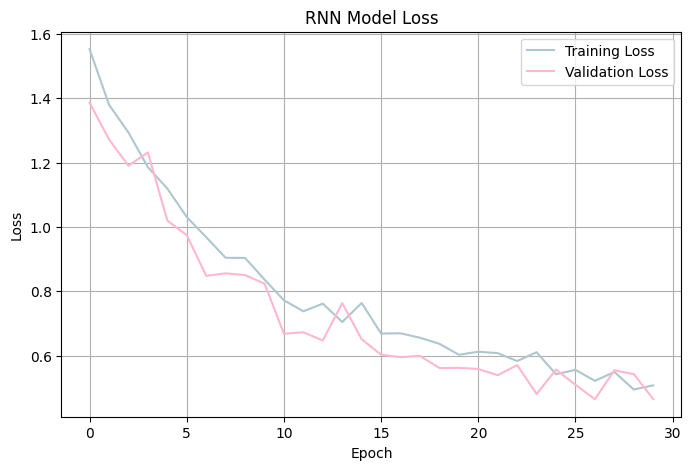

In [46]:
plt.figure(figsize=(8,5))
plt.plot(history_rnn.history['loss'],color='#AEC6CF',label='Training Loss')
plt.plot(history_rnn.history['val_loss'],color='#FFB7CE',  label='Validation Loss')
plt.title('RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

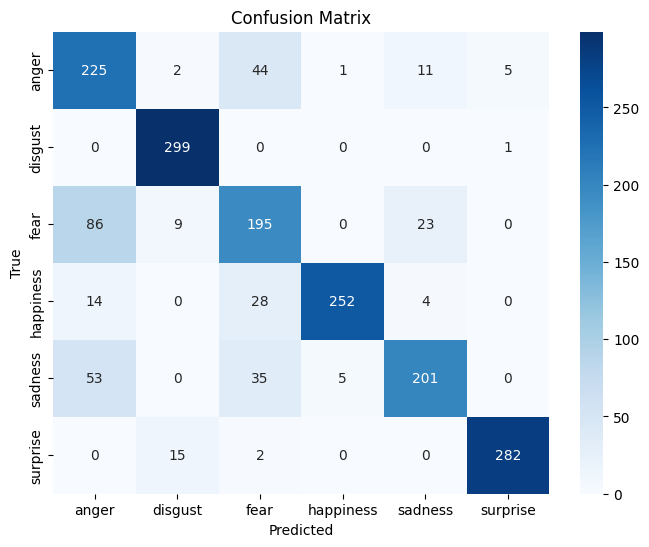

In [31]:
y_true = []
y_pred = []

for images, labels in val_ds_rnn:
    preds = model_rnn.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [32]:
model_rnn.save("best_rnn_model.h5")
import pickle
with open("rnn_history.pkl", "wb") as f:
    pickle.dump(history_rnn, f)

In [33]:
accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"RNN Validation Accuracy: {accuracy:.4f}")


RNN Validation Accuracy: 0.8114


Comparaison CNN vs RNN:


In [34]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    return acc, precision, recall, f1


In [37]:
val_ds_cnn = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)



Found 9000 files belonging to 6 classes.
Using 1800 files for validation.


In [38]:
y_true_cnn = []
y_pred_cnn = []

for images, labels in val_ds_cnn:
    preds = model.predict(images, verbose=0)
    y_true_cnn.extend(labels.numpy())
    y_pred_cnn.extend(np.argmax(preds, axis=1))

y_true_cnn = np.array(y_true_cnn)
y_pred_cnn = np.array(y_pred_cnn)

In [39]:
y_true_rnn = []
y_pred_rnn = []

for images, labels in val_ds_rnn:
    preds = model_rnn.predict(images, verbose=0)
    y_true_rnn.extend(labels.numpy())
    y_pred_rnn.extend(np.argmax(preds, axis=1))

y_true_rnn = np.array(y_true_rnn)
y_pred_rnn = np.array(y_pred_rnn)


In [40]:
cnn_acc, cnn_prec, cnn_rec, cnn_f1 = evaluate_model(y_true_cnn, y_pred_cnn)
rnn_acc, rnn_prec, rnn_rec, rnn_f1 = evaluate_model(y_true_rnn, y_pred_rnn)

In [41]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["CNN", "RNN"],
    "Accuracy": [cnn_acc, rnn_acc],
    "Precision": [cnn_prec, rnn_prec],
    "Recall": [cnn_rec, rnn_rec],
    "F1-score": [cnn_f1, rnn_f1]
})

print(results)


  Model  Accuracy  Precision    Recall  F1-score
0   CNN  0.963333   0.964323  0.963333  0.963154
1   RNN  0.811942   0.825955  0.811942  0.814567


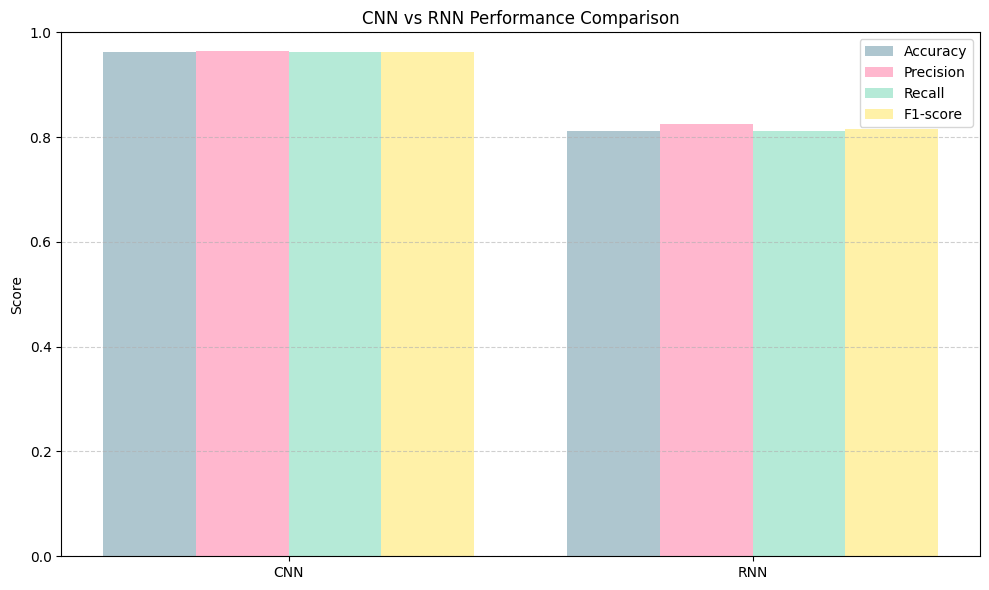

In [44]:
import matplotlib.pyplot as plt
import numpy as np

models = ['CNN', 'RNN']
accuracy = [cnn_acc, rnn_acc]
precision = [cnn_prec, rnn_prec]
recall = [cnn_rec, rnn_rec]
f1 = [cnn_f1, rnn_f1]

x = np.arange(len(models))
width = 0.2

# color palette
colors = {
    "Accuracy": "#AEC6CF",
    "Precision": "#FFB7CE",
    "Recall": "#B5EAD7",
    "F1-score": "#FFF1A8"
}

plt.figure(figsize=(10,6))

plt.bar(x - 1.5*width, accuracy, width, label='Accuracy', color=colors["Accuracy"])
plt.bar(x - 0.5*width, precision, width, label='Precision', color=colors["Precision"])
plt.bar(x + 0.5*width, recall, width, label='Recall', color=colors["Recall"])
plt.bar(x + 1.5*width, f1, width, label='F1-score', color=colors["F1-score"])

plt.xticks(x, models)
plt.ylabel('Score')
plt.title('CNN vs RNN Performance Comparison')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
